### Overview about the project:
In this project I will overview the dataset 525-bird-species. I will explore the data, transform it into a format for modeling, and then create classification models to predict the species of birds given a picture of a bird.

### About The Data:

Data set of 525 bird species. 84635 training images, 2625 test images and 2625 validation images
All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 525 sub directories, one for each bird species

### Summary Of Methods:

For each model, I used the imagedatagenerator in keras. I created each model as described below. Each model is compiled using a batchsize/samples ratio for the epochs_per_step (on training and validation steps). The compiled models are fit to the generator data for epochs required with patience of 5. I graphed the validation and training data loss and accuracy as a function of epochs. Finally, the third dataset - test - was compared to the model to give a true accuracy and loss value for each fit model.

### Analysis of Results:
Best accuracy achived by MobileNet(94.5% accuracy)

In [2]:
#Import packages used here:

import numpy as np
import os
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# setup my directories
train_directory = '../input/100-bird-species/train'
test_directory = '../input/100-bird-species/test'
val_directory = '../input/100-bird-species/valid'

In [4]:
categories = os.listdir(train_directory) # list the names of the categories that in my data
print(str(len(categories)),'CATEGORIES are ', categories)

category_count = len(categories)
# we will use "category_count" as the number of classes that we need to classify instead of typing 525 because the data is continuously increasing

525 CATEGORIES are  ['DALMATIAN PELICAN', 'BLACK BREASTED PUFFBIRD', 'WATTLED CURASSOW', 'AMERICAN WIGEON', 'CARMINE BEE-EATER', 'GAMBELS QUAIL', 'UMBRELLA BIRD', 'AMERICAN KESTREL', 'AMERICAN GOLDFINCH', 'BLUE GROSBEAK', 'PALM NUT VULTURE', 'DUSKY LORY', 'AUCKLAND SHAQ', 'BLACK THROATED WARBLER', 'YELLOW CACIQUE', 'STRIPPED SWALLOW', 'VERMILION FLYCATHER', 'CAPE MAY WARBLER', 'RED TAILED HAWK', 'GURNEYS PITTA', 'INDIAN ROLLER', 'SNOW GOOSE', 'GREEN WINGED DOVE', 'AZURE TANAGER', 'GREEN MAGPIE', 'BANDED BROADBILL', 'AFRICAN PYGMY GOOSE', 'INDIGO FLYCATCHER', 'GREY PLOVER', 'TOUCHAN', 'HYACINTH MACAW', 'HARLEQUIN DUCK', 'ABYSSINIAN GROUND HORNBILL', 'CALIFORNIA QUAIL', 'BALD IBIS', 'WOOD THRUSH', 'RUBY THROATED HUMMINGBIRD', 'INDIGO BUNTING', 'ALBERTS TOWHEE', 'SORA', 'HOODED MERGANSER', 'ROSEATE SPOONBILL', 'CAPE ROCK THRUSH', 'BLUE COAU', 'CALIFORNIA CONDOR', 'BORNEAN PHEASANT', 'BARN SWALLOW', 'TAIWAN MAGPIE', 'SPLENDID WREN', 'RED BILLED TROPICBIRD', 'BLACK THROATED BUSHTIT', 'CHINE

In [5]:
augmented_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') 

general_datagen = ImageDataGenerator(rescale = 1./255) # for training, validation and testing data

train_generator = general_datagen.flow_from_directory(
    train_directory,
    target_size = (224, 224),
    batch_size = 32
)
valid_generator = general_datagen.flow_from_directory(
    val_directory,
    target_size = (224, 224),
    batch_size = 32
)
test_generator = general_datagen.flow_from_directory(
    test_directory,
    target_size = (224, 224),
    batch_size = 32
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


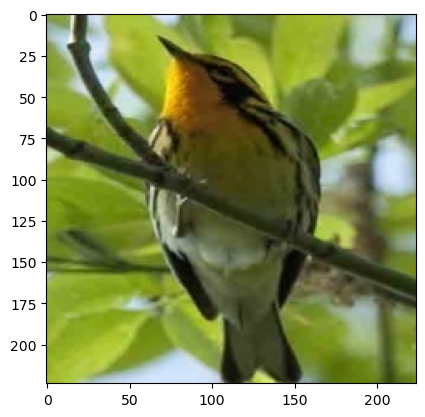

In [6]:
# ploting a sample from my data
def plot_image(generator):
    images_in_batch = next(generator) # images_in_batch will output (batch_size, height, width, n_channels)
    img = images_in_batch[0][0] # img will output (height, width, n_chennels)
    
    plt.imshow(img)

plot_image(train_generator)

In [7]:
# i will be using it to determine steps_per_epoch in my models.
train_groups = len(train_generator) 
valid_groups = len(valid_generator) # validation_step

print(f"Train groups: {train_groups}")
print(f"Validation groups: {valid_groups}")

Train groups: 2645
Validation groups: 83


## Playing with my base model

In [8]:
# convolution layer that we will be used in out model i added batch normalization to accelerate the model and for generalization
def conv_layer(inputs, filters, kernel_size=3, padding="valid"):
    x = layers.Conv2D(filters = filters, kernel_size = kernel_size, padding = padding, use_bias = False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    return x
# pooling layer i added dropout cause it help my model to reduce the overfitting
def pooling_layer(inputs, pool_size = 2, dropout_rate=0.5):
    x = layers.MaxPooling2D(pool_size = pool_size)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    return x

# this dense layer i will not only use it for my base model i will use it in the pretrained model too
def dense_layer(inputs, out, dropout_rate = 0.5):
    x = layers.Dense(out)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    
    return x

In [9]:
# in first my model was only two blocks gradually from 64 to 128 filters and gives me an accuracy of 55%
# so i added the dropouts and the batch normalization that above and set my filters to 64 and to make it better i added another block
# and changes in the dense layer before my output and play with my optimizer, the model gives me an acc of +75& on the test data
# i stoped then, with more to add to my arch to make it better, i can add residual connection to it and play with things but i stopped cause it take time and the gpu

keras.backend.clear_session()

inputs = keras.Input(shape = (224, 224, 3))

x = conv_layer(inputs, 64, padding = "same")  # 224x224
x = conv_layer(x, 64)                         # 222x222
x = pooling_layer(x)                          # 111x111

x = conv_layer(x, 64, padding = "same")       # 111x111
x = conv_layer(x, 64)                         # 109x109
x = pooling_layer(x)                          # 54x54

x = conv_layer(x, 64, padding = "same")       # 54x54
x = conv_layer(x, 64)                         # 52X52
x = pooling_layer(x)                          # 26x26

x = conv_layer(x, 64, padding = "same")       # 26x26

x = layers.Flatten()(x)                       # 26*26*64

x = dense_layer(x, 512)

outputs = layers.Dense(category_count, activation = "softmax")(x)

base_model = keras.Model(inputs, outputs)

base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1728      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36864     
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 64)     256       
 hNormalization)                                             

In [10]:
base_model.compile(optimizer =keras.optimizers.Adam(lr = 0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = base_model.fit( 
    train_generator,
    steps_per_epoch = train_groups,
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    keras.callbacks.ModelCheckpoint(
            filepath = "intial_model.keras",
            save_best_only = True,
            monitor = "val_loss")
    ])

Epoch 1/20


2023-09-11 02:21:09.652783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2645/2645 [==============================] - 762s 282ms/step - loss: 4.4991 - accuracy: 0.1611 - val_loss: 2.4878 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 2/20
2645/2645 [==============================] - 509s 192ms/step - loss: 2.6748 - accuracy: 0.4103 - val_loss: 1.8475 - val_accuracy: 0.5737 - lr: 0.0010
Epoch 3/20
2645/2645 [==============================] - 508s 192ms/step - loss: 1.9365 - accuracy: 0.5481 - val_loss: 1.5691 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 4/20
2645/2645 [==============================] - 509s 192ms/step - loss: 1.4269 - accuracy: 0.6466 - val_loss: 1.2523 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 5/20
2645/2645 [==============================] - 509s 193ms/step - loss: 1.0463 - accuracy: 0.7284 - val_loss: 1.2173 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 6/20
2645/2645 [==============================] - 511s 193ms/step - loss: 0.7580 - accuracy: 0.7926 - val_loss: 1.2041 - val_accuracy: 0.7162 - lr: 0.0010
Epoch 7/20
2645/2645 [=======================

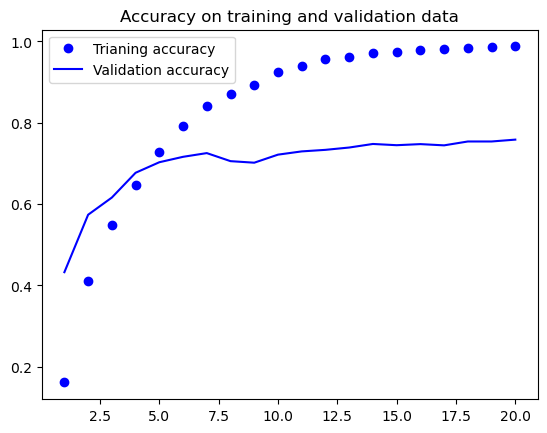

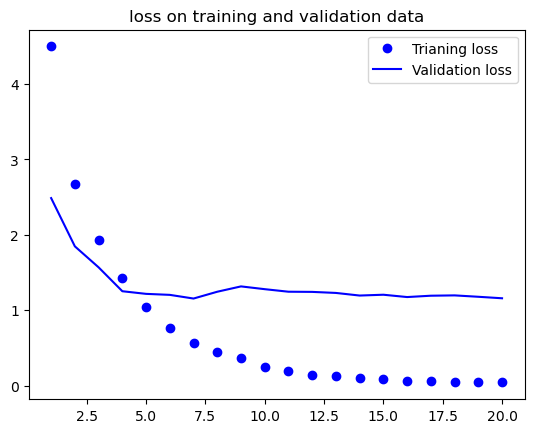

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

In [12]:
# testing the model on the testset
test_model_base = keras.models.load_model("intial_model.keras")
_, test_acc = test_model_base.evaluate(test_generator)
print(f"The accuracy of the intial model on the test set is : {test_acc:.3f}")

83/83 [==============================] - 25s 294ms/step - loss: 0.9809 - accuracy: 0.7589
The accuracy of the intial model on the test set is : 0.759


## Transfer learning

#### we will use transfer learnig as feature extraction we will use some models, i used (VGG16 & mobilenet and (Xception"i delete it cause its performance like mobilenet in acc and it take longer time time"))

### The VGG16 model

In [13]:
# first it gives me an acc of 75% and after some changes with the dense layer and the callbacks it gives me an acc of almost 80% on my test data
# but the loss i didn't love it, it get higher and make much changes but it didn't get well!
keras.backend.clear_session()

# load the model
conv_base_vgg16 = keras.applications.vgg16.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3)
)
conv_base_vgg16.trainable = False # beacuse we will use it as a feature extraction

inputs = keras.Input(shape = (224, 224, 3))

x = conv_base_vgg16(inputs)

x = layers.Flatten()(x)

x = dense_layer(x, 512)

outputs = layers.Dense(category_count, activation = "softmax")(x)
vgg16_model = keras.Model(inputs, outputs)

vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                             

In [14]:
vgg16_model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"]
)
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
    
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    
    keras.callbacks.ModelCheckpoint( filepath = "vgg16_model.keras",save_best_only = True,monitor = "val_loss")
]

history = vgg16_model.fit( 
    train_generator, 
    steps_per_epoch = train_groups, 
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
2645/2645 [==============================] - 663s 250ms/step - loss: 3.5511 - accuracy: 0.2911 - val_loss: 15.6625 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 2/20
2645/2645 [==============================] - 238s 90ms/step - loss: 1.9253 - accuracy: 0.5480 - val_loss: 61.1694 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 3/20
2645/2645 [==============================] - ETA: 0s - loss: 1.3889 - accuracy: 0.6543
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
2645/2645 [==============================] - 208s 78ms/step - loss: 1.3889 - accuracy: 0.6543 - val_loss: 32.3932 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 4/20
2645/2645 [==============================] - 212s 80ms/step - loss: 0.9059 - accuracy: 0.7596 - val_loss: 29.4133 - val_accuracy: 0.7577 - lr: 7.0000e-04
Epoch 5/20
2645/2645 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.8115
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
2645/2645 [===

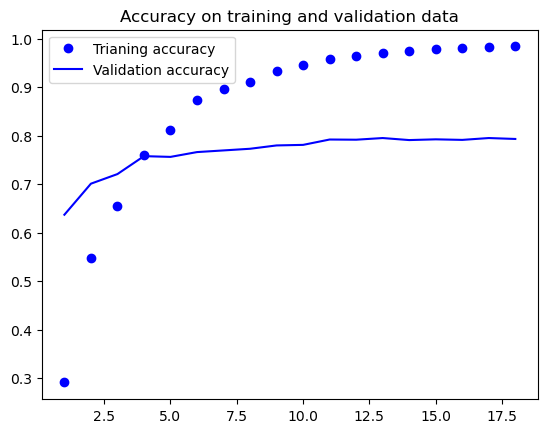

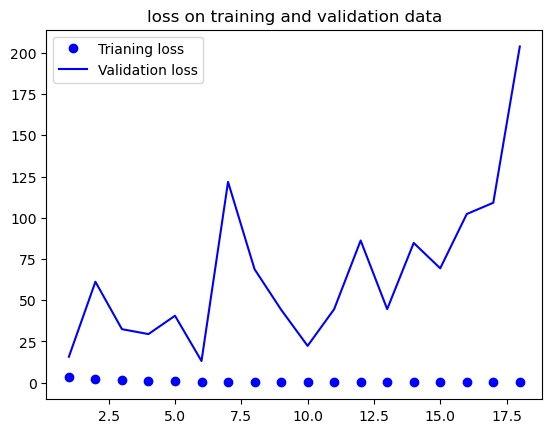

In [15]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

In [16]:
test_model_vgg16 = keras.models.load_model("vgg16_model.keras")
_, test_acc = test_model_vgg16.evaluate(test_generator)
print(f"The accuracy of the vgg16 model on the test set is : {test_acc:.3f}")

83/83 [==============================] - 22s 261ms/step - loss: 68.2850 - accuracy: 0.7962
The accuracy of the vgg16 model on the test set is : 0.796


### MobileNet

In [18]:
keras.backend.clear_session()

base_mobilenet = keras.applications.MobileNet(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (224, 224, 3)
)
base_mobilenet.trainable = False

inputs = keras.Input(shape = (224, 224, 3))

x = base_mobilenet(inputs)

x = layers.Flatten()(x)

x = dense_layer(x, 512)

outputs = layers.Dense(category_count, activation = "softmax")(x)
mobilenet_model = keras.Model(inputs, outputs)

17225924/17225924 [==============================] - 0s 0us/step


In [19]:
mobilenet_model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
                        loss = "categorical_crossentropy",
                        metrics = ["accuracy"]
)
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
    
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, patience = 2, verbose = 1),
    
    keras.callbacks.ModelCheckpoint( filepath = "mobilenet_model.keras",save_best_only = True,monitor = "val_loss")
]
history = mobilenet_model.fit( 
    train_generator, 
    steps_per_epoch = train_groups, 
    epochs = 20, # adding more epochs will increase the acc like 1% or 2%
    validation_data = valid_generator,
    validation_steps = valid_groups,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
2645/2645 [==============================] - 540s 201ms/step - loss: 1.8923 - accuracy: 0.5800 - val_loss: 0.4492 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 2/20
2645/2645 [==============================] - 186s 70ms/step - loss: 0.6131 - accuracy: 0.8347 - val_loss: 0.3658 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 3/20
2645/2645 [==============================] - 196s 74ms/step - loss: 0.3689 - accuracy: 0.8935 - val_loss: 0.3286 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 4/20
2645/2645 [==============================] - 204s 77ms/step - loss: 0.2698 - accuracy: 0.9183 - val_loss: 0.3182 - val_accuracy: 0.9139 - lr: 0.0010
Epoch 5/20
2645/2645 [==============================] - 194s 74ms/step - loss: 0.2156 - accuracy: 0.9337 - val_loss: 0.3342 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 6/20
2645/2645 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9444
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
2645/2645 [==============

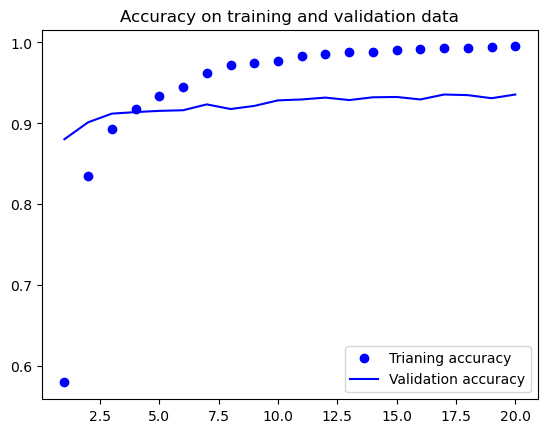

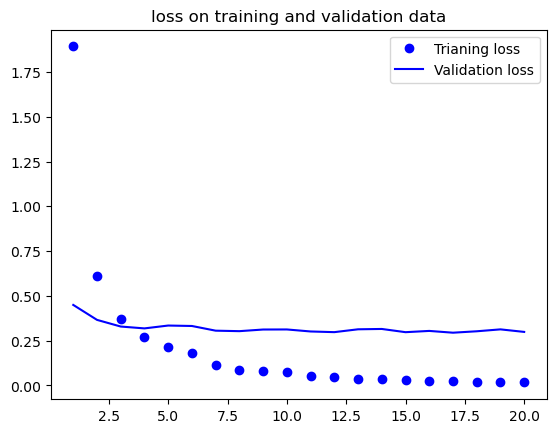

In [20]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Trianing accuracy")
plt.plot(epochs, val_accuracy, "b-", label = "Validation accuracy")
plt.title("Accuracy on training and validation data")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Trianing loss")
plt.plot(epochs, val_loss, "b-", label = "Validation loss")
plt.title("loss on training and validation data")
plt.title("loss on training and validation data")
plt.legend()
plt.show()

In [21]:
test_model_mobile = keras.models.load_model("mobilenet_model.keras")
_, test_acc = test_model_mobile.evaluate(test_generator)
print(f"The accuracy of the mobilenet model on the test set is : {test_acc:.3f}")

83/83 [==============================] - 20s 234ms/step - loss: 0.1957 - accuracy: 0.9497
The accuracy of the mobilenet model on the test set is : 0.950
